# Triplet Loss with Faces

In [ ]:
!pip install torch

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 204kB 5.5MB/s 


### Import Librairies

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import sys
import os

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

### Define Loss

In [ ]:
class TripletLoss(nn.Module):

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1) 
        distance_negative = (anchor - negative).pow(2).sum(1) 
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [ ]:
anchor, positive, negative = torch.tensor([[1, 2]], dtype=torch.float32), torch.tensor([[2, 2]], dtype=torch.float32),torch.tensor([[2, 2]], dtype=torch.float32)

margin = 1. #0.5

triplet_loss = TripletLoss(margin)
triplet_loss(anchor, positive, negative)

tensor(1.)

### Generate Data

In [ ]:
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

import tarfile
if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

Extracting image files...


In [ ]:
PATH = "lfw/lfw-deepfunneled/"
USE_SUBSET = True

In [ ]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = dirs[:] #:500
    
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

number of classes: 5749


In [ ]:
# read all directories
img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(PATH+directory))] 
             for directory,c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v:k for k,v in enumerate(all_images_path)}
id_to_path = {v:k for k,v in path_to_id.items()}

In [ ]:
# build mappings between images and class
classid_to_ids = {k:[path_to_id[path] for path in v] for k,v in img_paths.items()}
id_to_classid = {v:c for c,imgs in classid_to_ids.items() for v in imgs}

In [ ]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(PATH+path)),0)]
    return np.vstack(all_imgs)

In [ ]:
all_imgs = open_all_images(id_to_path)
mean = np.mean(all_imgs, axis=(0,1,2))
all_imgs -= mean
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

((13233, 60, 60, 3), '1143.3312Mo')

In [ ]:
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    
    pos_pairs = list(itertools.combinations(imgs, 2))
    
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [ ]:
def build_positive_pairs(class_id_range):
    listX1 = []
    listX2 = []
    
    for class_id in class_id_range:
        pos = build_pos_pairs_for_id(class_id)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            
    perm = np.random.permutation(len(listX1))
    return np.array(listX1)[perm], np.array(listX2)[perm]

In [ ]:
split_num = int(num_classes * 0.8)

In [ ]:
Xa_train, Xp_train = build_positive_pairs(range(0, split_num))
Xa_test, Xp_test = build_positive_pairs(range(split_num, num_classes-1))

# Gather the ids of all images that are used for train and test
all_img_train_idx = list(set(Xa_train) | set(Xp_train))
all_img_test_idx = list(set(Xa_test) | set(Xp_test))

In [ ]:
Xa_train.shape, Xp_train.shape, all_imgs.shape

((12018,), (12018,), (13233, 60, 60, 3))

In [ ]:
BATCH_SIZE = 128
BATCH_TEST_SIZE = 32

In [ ]:
class TripletGenerator(nn.Module):
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx):
        self.cur_img_index = 0
        self.cur_img_pos_index = 0
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train  # Anchors
        self.Xp = Xp_train
        self.cur_train_index = 0
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):

        image_transforms = transforms.Compose(
              [
                  transforms.ToTensor(),
              ]
          )
        
        
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size

        imgs_a = self.Xa[low_index:high_index]  # Anchors
        imgs_p = self.Xp[low_index:high_index]  # Positives
        imgs_n = random.sample(self.neg_imgs_idx, imgs_a.shape[0])  # Negatives
        #imgs_n = torch.tensor(imgs_n)

        imgs_a = self.imgs[imgs_a]
        imgs_p = self.imgs[imgs_p]
        imgs_n = self.imgs[imgs_n]

        anchors = torch.zeros((self.batch_size,3,60,60))
        positives = torch.zeros((self.batch_size,3,60,60))
        negatives = torch.zeros((self.batch_size,3,60,60))

        for batch in range(self.batch_size):
          #anchor = imgs[batch]
          anchors[batch]=image_transforms(imgs_a[batch])
          positives[batch]=image_transforms(imgs_p[batch])
          negatives[batch]=image_transforms(imgs_n[batch])
            
        # We also a null vector as placeholder for output, but it won't be needed:
        #return (imgs_a, imgs_p, imgs_n)
        return (anchors, positives, negatives)

In [ ]:
gen = TripletGenerator(Xa_train, Xp_train, BATCH_SIZE, all_imgs, all_img_train_idx)

In [ ]:
xa, xp, xn = gen[0]

xa.shape, xp.shape, xn.shape

(torch.Size([128, 3, 60, 60]),
 torch.Size([128, 3, 60, 60]),
 torch.Size([128, 3, 60, 60]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


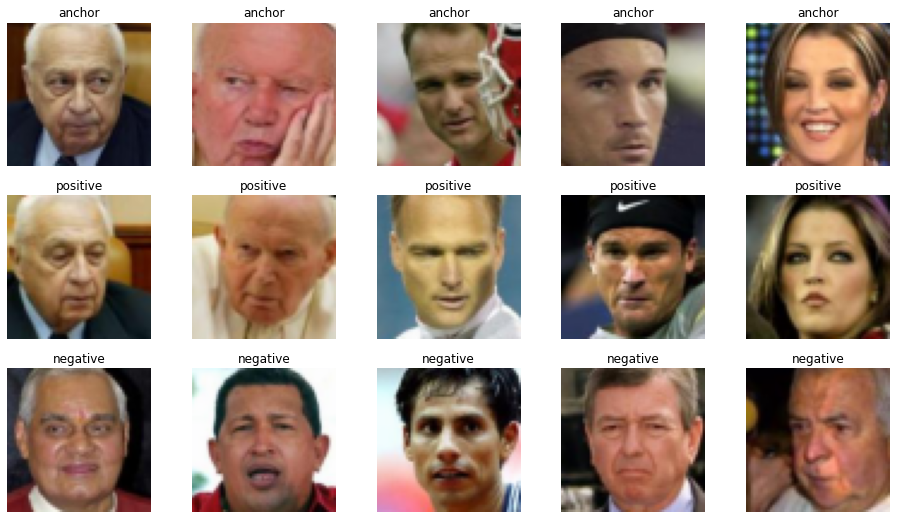

In [ ]:
plt.figure(figsize=(16, 9))

xa = xa.numpy()
xp = xp.numpy()
xn = xn.numpy()

for i in range(5):
    x = xa[i].transpose((1, 2, 0))
    plt.subplot(3, 5, i + 1)
    plt.title("anchor")
    plt.imshow((x + mean)/255)
    plt.axis('off')
    
for i in range(5):
    x = xp[i].transpose((1, 2, 0))
    plt.subplot(3, 5, i + 6)
    plt.title("positive")
    plt.imshow((x + mean) / 255)
    plt.axis('off')
    
for i in range(5):
    x = xn[i].transpose((1, 2, 0))
    plt.subplot(3, 5, i + 11)
    plt.title("negative")
    plt.imshow((x + mean) / 255)
    plt.axis('off')
    
plt.show()

### Define Network

In [ ]:
class TripletLearner(nn.Module):
    
    def __init__(self):
        super(TripletLearner, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=15 * 15 * 32, out_features=40),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features= 40, out_features=64)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*15*15)
        x = self.fc(x)
        return x

In [ ]:
triplet_learner = TripletLearner() #.float()

In [ ]:
xa, xp, xn = gen[0]

xa.shape, xp.shape, xn.shape

(torch.Size([128, 3, 60, 60]),
 torch.Size([128, 3, 60, 60]),
 torch.Size([128, 3, 60, 60]))

In [ ]:
data_size = 0

batch_size = xa.element_size() * xa.nelement()
tic = perf_counter()
while perf_counter() - tic < 10:
    triplet_learner(xa)
    data_size += batch_size
toc = perf_counter()
print(f"Model throughput: {data_size / 1e6 / (toc - tic):.1f} MB/s")

Model throughput: 11.3 MB/s


### Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
triplet_learner.to(device)

lr = 1e-3
optimizer = optim.Adam(triplet_learner.parameters(), lr=lr)

margin = 1. #0.5
criterion = TripletLoss(margin)

epochs = 30

In [ ]:
gen_train = TripletGenerator(Xa_train, Xp_train, BATCH_SIZE, all_imgs, all_img_train_idx)
train_loader = DataLoader(gen_train, batch_size=None, shuffle=True)

gen_test = TripletGenerator(Xa_test, Xp_test, BATCH_TEST_SIZE, all_imgs, all_img_test_idx)
test_loader = DataLoader(gen_test, batch_size=None, shuffle=True)

In [ ]:
xa, xp, xn = gen_train[0]

xa.shape, xp.shape, xn.shape

(torch.Size([128, 3, 60, 60]),
 torch.Size([128, 3, 60, 60]),
 torch.Size([128, 3, 60, 60]))

In [ ]:
!nvidia-smi

Mon May 10 09:07:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
total_loss = []
validation_loss = []

triplet_learner.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    running_test = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()

        anchor_out = triplet_learner(anchor_img)
        positive_out = triplet_learner(positive_img)
        negative_out = triplet_learner(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())

        running_test_loss = []

        for _, (anchor_test, positive_test, negative_test) in enumerate(test_loader):

          anchor_test = anchor_test.to(device)
          positive_test = positive_test.to(device)
          negative_test = negative_test.to(device)
          
          optimizer.zero_grad()

          anchor_test_out = triplet_learner(anchor_test)
          positive_test_out = triplet_learner(positive_test)
          negative_test_out = triplet_learner(negative_test)

          test_loss = criterion(anchor_test_out, positive_test_out, negative_test_out)
          
          running_test_loss.append(test_loss.cpu().detach().numpy())
        
        running_test.append(np.mean(running_test_loss))

    validation_loss.append(np.mean(running_test))

    total_loss.append(np.mean(running_loss))

    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epoch: 1/30 - Loss: 0.8137


Epoch: 2/30 - Loss: 0.6501


Epoch: 3/30 - Loss: 0.5893


Epoch: 4/30 - Loss: 0.5232


Epoch: 5/30 - Loss: 0.4450


Epoch: 6/30 - Loss: 0.4017


Epoch: 7/30 - Loss: 0.3649


Epoch: 8/30 - Loss: 0.3252


Epoch: 9/30 - Loss: 0.3084


Epoch: 10/30 - Loss: 0.2819


Epoch: 11/30 - Loss: 0.2891


Epoch: 12/30 - Loss: 0.2606


Epoch: 13/30 - Loss: 0.2500


Epoch: 14/30 - Loss: 0.2507


Epoch: 15/30 - Loss: 0.2351


Epoch: 16/30 - Loss: 0.2226


Epoch: 17/30 - Loss: 0.2048


Epoch: 18/30 - Loss: 0.2085


In [ ]:
# torch.save(triplet_learner.state_dict(), './model/model1.pth')

In [ ]:
plt.plot(np.arange(len(total_loss)),total_loss)
plt.plot(np.arange(len(validation_loss)),validation_loss)
plt.show()

In [ ]:
xa,xp,xn = gen_test[0]

xa.shape, xp.shape, xn.shape

In [ ]:
plt.figure(figsize=(16, 9))

xa_num = xa.numpy()
xp_num = xp.numpy()
xn_num = xn.numpy()

x = xa_num[0].transpose((1, 2, 0))
plt.subplot(3, 5, 1)
plt.title("anchor")
plt.imshow((x + mean)/255)
plt.axis('off')
    
x = xp_num[0].transpose((1, 2, 0))
plt.subplot(3, 5, 6)
plt.title("positive")
plt.imshow((x + mean) / 255)
plt.axis('off')
    
x = xn_num[0].transpose((1, 2, 0))
plt.subplot(3, 5, 11)
plt.title("negative")
plt.imshow((x + mean) / 255)
plt.axis('off')
    
plt.show()

In [ ]:
anchor_test = xa.to(device)
positive_test = xp.to(device)
negative_test = xn.to(device)
          
optimizer.zero_grad()

anchor_test_out = triplet_learner(anchor_test)
positive_test_out = triplet_learner(positive_test)
negative_test_out = triplet_learner(negative_test)

test_loss = criterion(anchor_test_out, positive_test_out, negative_test_out)

In [ ]:
test_loss